    - 목차 
      1. 문제 정의 : 주가 변화를 바탕으로 다음 주가 변동 예측
    
    Daily Minimum Temperatures in Melbourne : 온도 변화를 다루는 시계열
     1) package loding 
     2) 오늘 다루게 될 시계열(Time Series)이란 것도 결국 시간 컬럼을 index로 하는 Series로 표현됩니다. 
        이터 파일은 Pandas를 통해 2개의 컬럼을 가진 DataFrame으로 변환되
       
     3) 시계열 안정성의 정성적 분석
     4) 결측치확인 
     결측치가 있는 데이터를 모두 삭제(drop)
     결측치 양옆의 값들을 이용해서 적절히 보간(interpolate)하여 대입
      ex) 2와 4 사이 데이터가 NaN이라면 이 값을 3으로 채우는 방식
      아래는 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수입니다.

    현재 타임 스텝 부터 window에 주어진 타임 스텝 이전 사이

    구간의 평균(rolling mean, 이동평균)과
    표준편차(rolling std, 이동표준편차)를
    시계열 데이터의 안정성을 시각화 방법을 통해 정성적으로 분석------------윗부분
    -----------------------------------------------------------------------------
    정량적 
    Augmented Dickey-Fuller Test(ADF Test) 라는 시계열 데이터의 안정성(stationary)을 테스트
    주어진 시계열 데이터가 안정적이지 않다라는 귀무가설(Null Hypothesis)를 세운 후,

    통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에

    이 시계열 데이터가 안정적이다라는 대립가설(Alternative Hypothesis)을 채택한다
     Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지를 Residual이라고 합니다. 
     뒤집어서 말하면 Trend+Seasonality+Residual=Original 이 성립한다는 뜻입니다.
     이러한 Decomposing은 시계열 데이터를 이해하는 중요한 관점을 제시해 줍니다.

In [47]:
#project
#STEP 1 : 시계열 데이터 준비
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
data_path = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv' 
df = pd.read_csv(data_path)
ts = df['Close']

ts.head()


0    48800.0
1    50300.0
2    50000.0
3    49950.0
4    48750.0
Name: Close, dtype: float64

In [53]:
#STEP 2-1: 각종 전처리 수행
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [54]:
#STEP 2-2: 각종 전처리 수행
# 로그 변환
ts_log = np.log(ts)

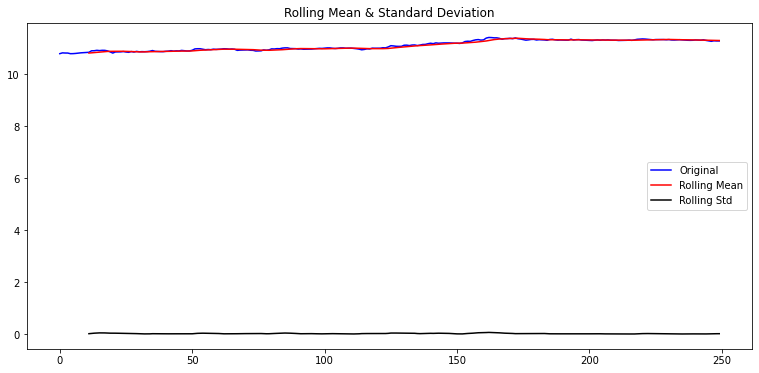

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


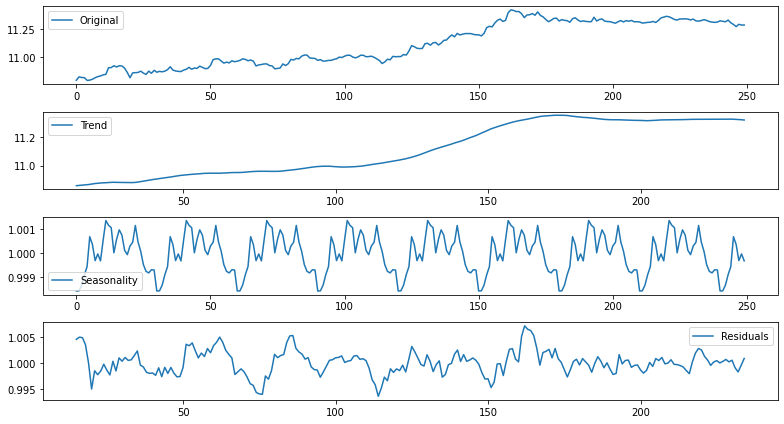

In [55]:
#STEP 3 : 시계열 안정성 분석
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

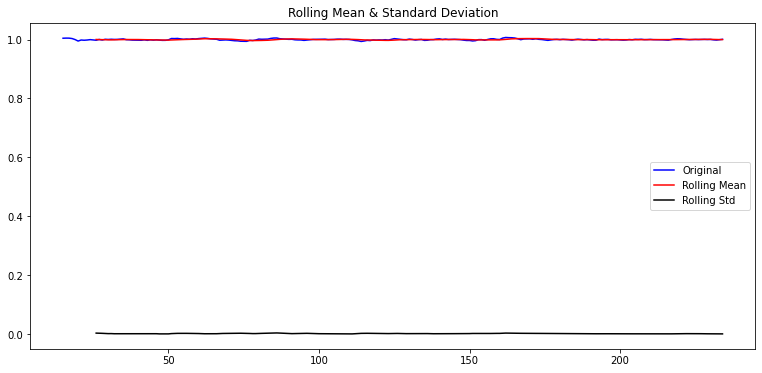

In [56]:
#STEP 3 : 시계열 안정성 분석
# Residual 안정성 확인
plt.rcParams["figure.figsize"] = (13,6)
residual.dropna(inplace=True)
plot_rolling_statistics(residual)

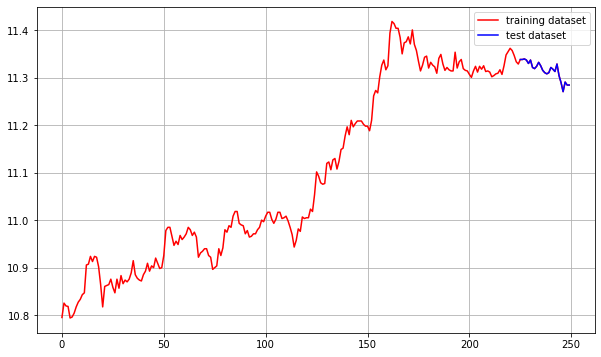

In [57]:
#STEP 4 : 학습, 테스트 데이터셋 생성
#data 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

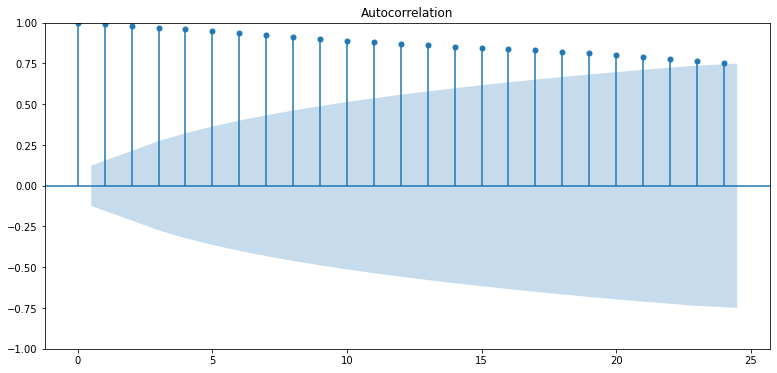

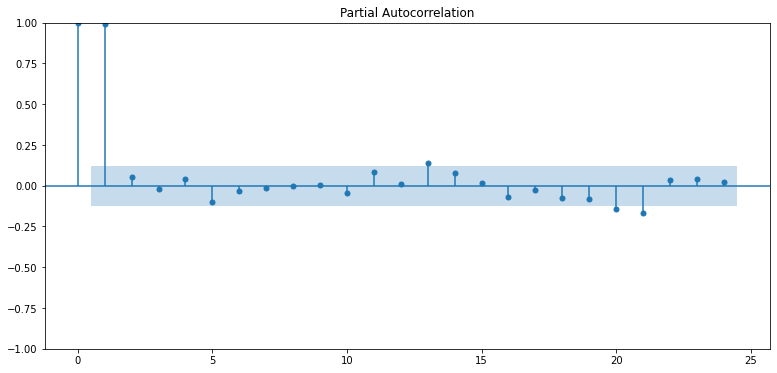

In [58]:
#STEP 5 : 적정 ARIMA 모수 찾기
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


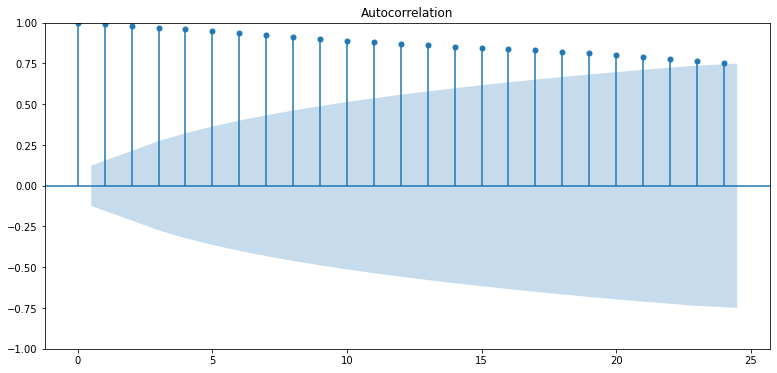

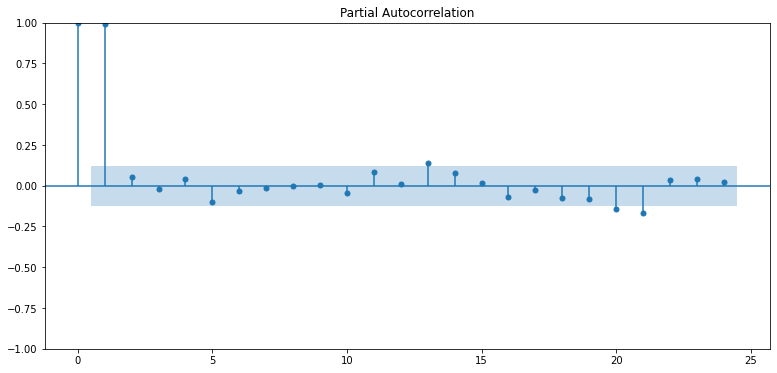

In [59]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


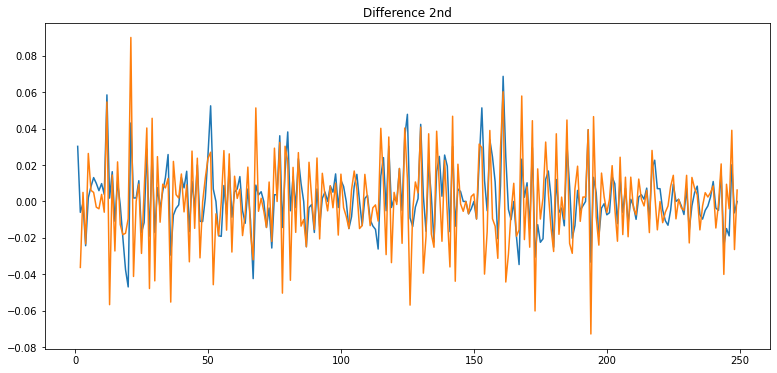

In [60]:
#STEP 5 : 적정 ARIMA 모수 찾기
# 차분 안정성 확인 -> d 구하기
# 1차 차#STEP 5 : 적정 ARIMA 모수 찾기
분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)


In [61]:
#STEP 6 : ARIMA 모델 훈련과 테스트
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Tue, 20 Sep 2022   AIC                          -1156.722
Time:                        05:55:00   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

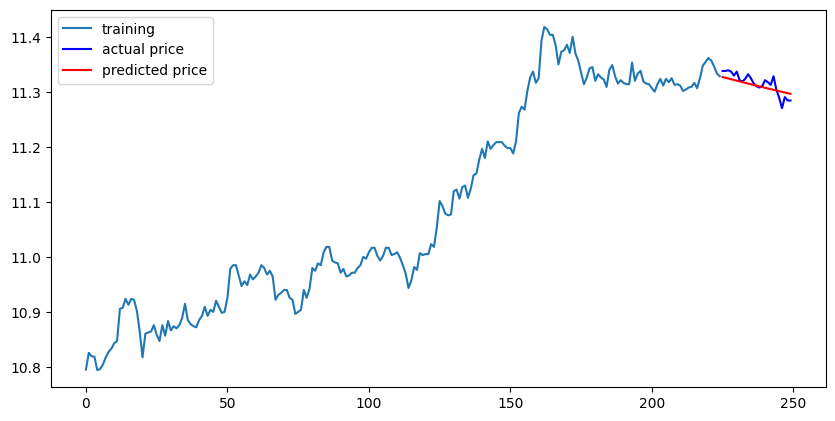

In [62]:
#STEP 6 : ARIMA 모델 훈련과 테스트
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [63]:
##STEP 6 : ARIMA 모델 훈련과 테스트
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


In [ ]:
#STEP 7 : 다른 주식 종목 예측해 보기